<a href="https://colab.research.google.com/github/Shivam-316/Bahdanau-Attention-NPL/blob/master/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 8.5 MB/s 


In [ ]:
import numpy  as np
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Data Pipeline

In [ ]:
import pathlib

In [ ]:
path_zip = tf.keras.utils.get_file('spa_to_eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True, cache_dir='/content/drive/MyDrive/datascience/attention')

In [ ]:
file_path = pathlib.Path(path_zip).parent/'spa-eng/spa.txt'

In [ ]:
def load_text(path):
  text = path.read_text(encoding = 'utf-8')
  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]
  inp = [pair[0] for pair in pairs]
  tar = [pair[1] for pair in pairs]
  return inp,tar

In [ ]:
tar,inp = load_text(file_path)

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
EXAMPLE_TEXT = tf.constant('¿Todavía está en casa?')
MAX_VOCAB = 5000

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(
    (inp,tar)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def tf_norm_and_split_punc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?,!¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
input_preprocessing = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=MAX_VOCAB, standardize=tf_norm_and_split_punc)
input_preprocessing.adapt(inp)
input_preprocessing.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
output_preprocessing = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=MAX_VOCAB, standardize=tf_norm_and_split_punc)
output_preprocessing.adapt(tar)
output_preprocessing.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
for input, target in dataset.take(1):
  print(input[:1])
  print(target[:1])
  EXAMPLE_INPUT_BATCH = input[:5]
  EXAMPLE_TARGET_BATCH = target[:5]

tf.Tensor([b'Este material se estira f\xc3\xa1cilmente.'], shape=(1,), dtype=string)
tf.Tensor([b'This material stretches easily.'], shape=(1,), dtype=string)


In [ ]:
EXAMPLE_TOKENS = input_preprocessing(EXAMPLE_INPUT_BATCH)
print(EXAMPLE_TOKENS)

tf.Tensor(
[[   2   40 3752   17    1 1520    4    3    0    0    0    0]
 [   2   15   11 2402 3952    4    3    0    0    0    0    0]
 [   2    8   24   18  957   75    4    3    0    0    0    0]
 [   2   13   76   36   42 1333   14  259   27   78   12    3]
 [   2  505    1   21   36  665    4    3    0    0    0    0]], shape=(5, 12), dtype=int64)


In [ ]:
INPUT_VOCAB = np.array(input_preprocessing.get_vocabulary())
tokens = INPUT_VOCAB[EXAMPLE_TOKENS[0].numpy()]
' '.join(tokens)

'[START] este material se [UNK] facilmente . [END]    '

Text(0.5, 1.0, 'MASK')

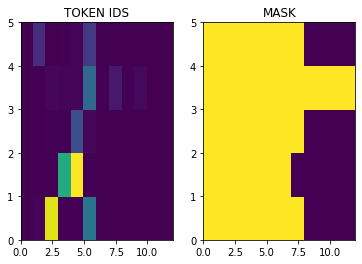

In [ ]:
plt.subplot(1,2,1)
plt.pcolormesh(EXAMPLE_TOKENS)
plt.title('TOKEN IDS')

plt.subplot(1,2,2)
plt.pcolormesh(EXAMPLE_TOKENS != 0)
plt.title('MASK')

### Model

#### Shape Checker

In [ ]:
class ShapeCheck():
  def __init__(self):
    self.shapes = {}
  
  def __call__(self, tensor, names, broadcast = False):
    if not tf.executing_eagerly():
      return
    
    if isinstance(names, str):
      names = (names,)
    
    shape = tf.shape(tensor)
    rank  = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')
    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dims = name
      else:
        old_dims = self.shapes.get(name, None)
      
      curr_dims = shape[i]
      if (broadcast and curr_dims == 1):
        continue
      if old_dims is None:
        self.shapes[name] = curr_dims
        continue
      
      if curr_dims != old_dims:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {curr_dims}\n"
                         f"    expected: {old_dims}\n")

#### Encoder

In [ ]:
EMBEDDING_DIMENTION = 256
UNITS = 1024

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, units, embedding_dims, input_vocab_size):
    super(Encoder, self).__init__()
    self.enc_units = units
    self.embed_dims = embedding_dims
    self.input_size = input_vocab_size

    self.embedding = tf.keras.layers.Embedding(self.input_size, embedding_dims)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')


  def call(self, tokens, state=None):
    check_shape = ShapeCheck()
    check_shape(tokens, ('batch', 't_steps')) # t_seps are words in sentence

    embedding = self.embedding(tokens)
    check_shape(embedding, ('batch', 't_steps', 'embed_dims'))

    output, state = self.gru(embedding, initial_state = state)
    check_shape(output, ('batch', 't_steps', 'enc_units'))
    check_shape(state, ('batch', 'enc_units'))

    return output, state

In [ ]:
example_tokens = input_preprocessing(EXAMPLE_INPUT_BATCH)
encoder = Encoder(UNITS, EMBEDDING_DIMENTION, input_preprocessing.vocabulary_size())
exp_enc_output, exp_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {EXAMPLE_INPUT_BATCH.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {exp_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {exp_enc_state.shape}')

Input batch, shape (batch): (5,)
Input batch tokens, shape (batch, s): (5, 12)
Encoder output, shape (batch, s, units): (5, 12, 1024)
Encoder state, shape (batch, units): (5, 1024)


### Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.units = units
    self.W1 = tf.keras.layers.Dense(self.units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(self.units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    check_shape = ShapeCheck()
    check_shape(query, ('batch', 't_steps_dec', 'query_units'))
    check_shape(value, ('batch', 't_steps', 'value_units'))
    check_shape(mask, ('batch', 't_steps'))

    w1_query = self.W1(query)
    check_shape(w1_query, ('batch', 't_steps_dec', 'att_units'))

    w2_key = self.W1(value)
    check_shape(w2_key, ('batch', 't_steps', 'att_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    check_shape(context_vector, ('batch', 't', 'value_units'))
    check_shape(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(UNITS)

# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 1024])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=exp_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (5, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (5, 2, 12)


Text(0.5, 1.0, 'Mask')

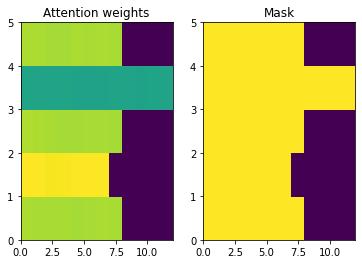

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### Decoder

In [ ]:
import typing

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: typing.Any
  enc_output: typing.Any
  mask: typing.Any

class DecoderOutput(typing.NamedTuple):
  logits: typing.Any
  attention_weights: typing.Any

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, units, embedding_dims, output_vocab_size):
    super(Decoder, self).__init__()
    self.dec_units = units
    self.embedding_dims = embedding_dims
    self.output_vocab_size = output_vocab_size

    self.attention = BahdanauAttention(self.dec_units)
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, self.embedding_dims)
    self.gru = tf.keras.layers.GRU(self.dec_units, recurrent_initializer='glorot_uniform', return_sequences=True, return_state= True)
    self.Wc = tf.keras.layers.Dense(self.dec_units, use_bias=False, activation= tf.math.tanh)
    self.Fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self, inputs: DecoderInput, state = None) -> typing.Tuple[DecoderOutput, tf.Tensor]:
    check_shape = ShapeCheck()
    check_shape(inputs.new_tokens, ('batch', 't_steps_dec'))
    check_shape(inputs.enc_output, ('batch', 't_steps', 'enc_units'))
    check_shape(inputs.mask, ('batch', 't_steps'))
    if state is not None:
      check_shape(state, ('batch', 'dec_units'))
    
    embeddings = self.embedding(inputs.new_tokens)
    check_shape(embeddings, ('batch', 't_steps_dec', 'dec_embedd_dims'))

    rnn_output, state = self.gru(embeddings, initial_state = state)
    check_shape(rnn_output, ('batch', 't_steps_dec', 'dec_units'))
    check_shape(state, ('batch', 'dec_units'))

    context_vector, attention_weights = self.attention(query = rnn_output, value = inputs.enc_output, mask = inputs.mask)
    check_shape(context_vector, ('batch', 't_steps_dec', 'dec_units'))
    check_shape(attention_weights, ('batch', 't_steps_dec', 't_steps'))

    rnn_out_and_context = tf.concat([context_vector, rnn_output], axis=-1)
    
    attention_vector = self.Wc(rnn_out_and_context)
    check_shape(attention_vector, ('batch', 't_steps_dec', 'dec_units'))

    logits = self.Fc(attention_vector)
    check_shape(logits, ('batch', 't_steps_dec', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [ ]:
decoder = Decoder(UNITS, EMBEDDING_DIMENTION, output_preprocessing.vocabulary_size())

In [ ]:
out

In [ ]:
example_output_tokens = output_preprocessing(EXAMPLE_TARGET_BATCH)
start_index = output_preprocessing._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
dec_result, dec_state = decoder(
    inputs = DecoderInput(
        new_tokens = first_token,
        enc_output = exp_enc_output,
        mask = (example_tokens != 0)
    ),
    state = exp_enc_state
)

print(f'logits shape: (batch_size, t_steps_dec, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

In [ ]:
sample_token = tf.random.categorical(dec_result.logits[:,0,:], num_samples=1) # more the log prob more the chance of selection so we want high prob for true target word

In [ ]:
sample_token

In [ ]:
OUTPUT_VOCAB = np.array(output_preprocessing.get_vocabulary())
first_word = OUTPUT_VOCAB[sample_token.numpy()]
first_word[:5]      #  first target must be in one of these others are used to cal loss

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sample_token,
                 exp_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

sample_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
second_word = OUTPUT_VOCAB[sample_token.numpy()]
second_word[:5]

### Training

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  
  def __call__(self, y_true, y_pred):
    check_shape = ShapeCheck()
    check_shape(y_true, ('batch', 't_steps_dec'))
    check_shape(y_pred, ('batch', 't_steps_dec', 'logits'))

    loss = self.loss(y_true, y_pred)
    check_shape(loss, ('batch', 't_steps_dec'))

    mask = tf.cast(y_true !=0, tf.float32)
    check_shape(mask, ('batch', 't_steps_dec'))

    loss*=mask
    return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, units, embedding_dims, input_preprocessor, output_preprocessor, use_tf_function=True):
    super(TrainTranslator, self).__init__()
    self.units = units
    self.embedding = embedding_dims
    self.use_tf_function = use_tf_function
    self.input_preprocessor = input_preprocessor
    self.output_preprocessor = output_preprocessor
    self.encoder = Encoder(self.units, self.embedding, self.input_preprocessor.vocabulary_size())
    self.decoder = Decoder(self.units, self.embedding, self.output_preprocessor.vocabulary_size())
    self.check_shape = ShapeCheck()

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, output_text):
  self.check_shape(input_text, ('batch',)) # not checking t-steps as can be diff in diff batches
  self.check_shape(output_text, ('batch',))

  input_tokens = self.input_preprocessor(input_text)
  target_tokens = self.output_preprocessor(output_text)
  self.check_shape(input_tokens, ('batch', 't_steps'))
  self.check_shape(target_tokens, ('batch', 't_steps_dec'))

  input_mask = (input_tokens != 0)
  self.check_shape(input_mask, ('batch', 't_steps'))

  target_mask = (target_tokens != 0)
  self.check_shape(target_mask, ('batch', 't_steps_dec'))

  return input_tokens, input_mask, target_tokens, target_mask

TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs
  input_tokens, input_mask, target_tokens, target_mask = self._preprocess(input_text, target_text)
  max_target_sen_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    enc_output, enc_state = self.encoder(input_tokens)
    self.check_shape(enc_output, ('batch', 't_steps', 'enc_units'))
    self.check_shape(enc_state, ('batch', 'enc_units'))

    dec_state = enc_state
    loss = tf.constant(0.0)

    for t_step_dec in tf.range(max_target_sen_length -1):
      next_tokens = target_tokens[:, t_step_dec:t_step_dec+2] # current input token and the the output to find loss
      step_loss, dec_state = self._one_step(next_tokens, enc_output, input_mask, dec_state)
      loss = loss + step_loss

    avg_loss = loss/tf.reduce_sum(tf.cast(target_mask, tf.float32))
  variables = self.trainable_variables
  gradients = tape.gradient(avg_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))
  return {'batch_loss': avg_loss}

TrainTranslator._train_step = _train_step

In [ ]:
def _one_step(self, next_tokens, enc_output, input_mask, dec_state):
  input_token, target_token = next_tokens[:,0:1], next_tokens[:,1:2]

  decoder_input = DecoderInput(input_token, enc_output, input_mask)
  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.check_shape(dec_result.logits, ('batch', '1_t_step_dec', 'logits'))
  self.check_shape(dec_result.attention_weights, ('batch', '1_t_step_dec', 't-steps'))
  self.check_shape(dec_state, ('batch', 'dec_units'))

  y_true = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y_true, y_pred)

  return step_loss, dec_state

TrainTranslator._one_step = _one_step

In [ ]:
translator = TrainTranslator(
    UNITS,
    EMBEDDING_DIMENTION,
    input_preprocessing,
    output_preprocessing,
    use_tf_function = False
)
translator.compile(optimizer = tf.optimizers.Adam(), loss = MaskedLoss())

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([EXAMPLE_INPUT_BATCH, EXAMPLE_TARGET_BATCH]))
print()

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(shape=[None], dtype=tf.string), 
                               tf.TensorSpec(shape=[None], dtype=tf.string)]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True
translator.train_step([EXAMPLE_INPUT_BATCH, EXAMPLE_TARGET_BATCH])

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([EXAMPLE_INPUT_BATCH, EXAMPLE_TARGET_BATCH]))
print()

#### Training Model

In [ ]:
translator = TrainTranslator(
    UNITS,
    EMBEDDING_DIMENTION,
    input_preprocessing,
    output_preprocessing,
)
translator.compile(optimizer = tf.optimizers.Adam(), loss = MaskedLoss())

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []
  
  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])
batch_loss = BatchLogs('batch_loss')

In [ ]:
translator.fit(dataset, epochs=3, callbacks=[batch_loss])
# translator.save_weights('/content/drive/MyDrive/datascience/attention/TrainTranslator')

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):
  def __init__(self, encoder, decoder, input_preprocessor, output_preprocessor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_preprocessor = input_preprocessor
    self.output_text_preprocessor = output_preprocessor

    self.output_text_from_tokens = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary = output_preprocessor.get_vocabulary(), mask_token = '',
        invert = True
    )

    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary = output_preprocessor.get_vocabulary(), mask_token = ''
    )

    token_mask_ids = index_from_string(['','[UNK]', '[START]']).numpy()
    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask
    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

In [ ]:
inf_translator = Translator(
    encoder = translator.encoder,
    decoder = translator.decoder,
    input_preprocessor = input_preprocessing,
    output_preprocessor = output_preprocessing
)

In [ ]:
def tokens_to_text(self, result_tokens):
  check_shape = ShapeCheck()
  check_shape(result_tokens, ('batch', 't_steps_dec'))

  result_text_tokens = self.output_text_from_tokens(result_tokens)
  check_shape(result_text_tokens, ('batch', 't_steps_dec'))

  result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
  check_shape(result_text, ('batch',))

  result_text = tf.strings.strip(result_text)
  return result_text
Translator.tokens_to_text = tokens_to_text

In [ ]:
sample_output_tokens = tf.random.uniform(
    shape=(5,2), minval= 0,
    maxval= output_preprocessing.vocabulary_size(),dtype= tf.int64
)
inf_translator.tokens_to_text(sample_output_tokens)

In [ ]:
def sample_tokens_fron_dec_logits(self, logits, temperature):
  check_shape = ShapeCheck()
  check_shape(logits, ('batch' ,'t_steps_dec', 'vocab'))
  check_shape(self.token_mask, ('vocab'))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  check_shape(token_mask, ('batch', 't_steps_dec', 'vocab'), broadcast= True)

  logits = tf.where(self.token_mask, -np.inf, logits)
  if temperature == 0.0:
    predicted_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits)
    predicted_tokens = tf.random.categorical(logits/temperature, num_samples=1)
  
  check_shape(predicted_tokens, ('batch', 't_steps_dec'))
  return predicted_tokens
Translator.sample_tokens_fron_dec_logits = sample_tokens_fron_dec_logits

In [ ]:
example_logits = tf.random.normal([5, 1, output_preprocessing.vocabulary_size()])
example_output_tokens = inf_translator.sample_tokens_fron_dec_logits(example_logits, temperature=1.0)
example_output_tokens

In [ ]:
def tanslator_unrolled(self, input_text, max_length=50, return_attention=True, temperature = 1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_preprocessor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill((batch_size,1), self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size,1], dtype=tf.bool)
  for _ in range(max_length):
    dec_input = DecoderInput(
        new_tokens,
        enc_output,
        (input_tokens!=0)
    )
    dec_result, dec_state = self.decoder(dec_input, state = dec_state)
    attention.append(dec_result.attention_weights)
    new_tokens = self.sample_tokens_fron_dec_logits(dec_result.logits, temperature)
    done = done | (new_tokens == self.end_token)
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    result_tokens.append(new_tokens)
    if tf.executing_eagerly() and tf.reduce_all(done):
      break
  result_tokens = tf.concat(result_tokens, axis=1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}
Translator.tanslator_unrolled =tanslator_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = inf_translator.tanslator_unrolled(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_tanslator_unrolled(self, input_text):
  return self.tanslator_unrolled(input_text)
Translator.tf_tanslator_unrolled = tf_tanslator_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = inf_translator.tf_tanslator_unrolled(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
def tanslator_symbolic(self, input_text, max_length=50, return_attention=True, temperature = 1.0):
  check_shape = ShapeCheck()
  check_shape(input_text, ('batch'))

  batch_size = tf.shape(input_text)[0]

  input_tokens = self.input_text_preprocessor(input_text)
  check_shape(input_tokens, ('batch', 't_steps'))

  enc_output, enc_state = self.encoder(input_tokens)
  check_shape(enc_output, ('batch', 't_steps', 'enc_units'))
  check_shape(enc_state, ('batch', 'enc_units'))

  dec_state = enc_state
  new_tokens = tf.fill((batch_size,1), self.start_token)
  check_shape(new_tokens, ('batch', 't1'))

  result_tokens = tf.TensorArray(dtype= tf.int64, size=1, dynamic_size=True) # size is dims excuding batch, so for int it will be 0, here it is 1 as batch, steps
  attention = tf.TensorArray(dtype= tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size,1], dtype=tf.bool)
  check_shape(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens,
        enc_output,
        (input_tokens!=0)
    )
    dec_result, dec_state = self.decoder(dec_input, state = dec_state)

    attention = attention.write(t, dec_result.attention_weights)
    new_tokens = self.sample_tokens_fron_dec_logits(dec_result.logits, temperature)
    done = done | (new_tokens == self.end_token)
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  result_tokens = result_tokens.stack() # stacks along axis 1
  check_shape(result_tokens, ('t_steps_dec','batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, axis = -1)
  result_tokens = tf.transpose(result_tokens, [1,0])
  check_shape(result_tokens, ('batch','t_steps_tokens'))

  result_text = self.tokens_to_text(result_tokens)
  check_shape(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    check_shape(attention_stack, ('t_steps_dec', 'batch', 't1', 't_steps'))
    attention_stack = tf.squeeze(attention_stack, 2)
    check_shape(attention_stack, ('t_steps_dec', 'batch','t_steps'))
    attention_stack = tf.transpose(attention_stack, [1,0,2])
    check_shape(attention_stack, ('batch', 't_steps_dec', 't_steps'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}
Translator.tanslator_symbolic = tanslator_symbolic

In [ ]:
%%time
result = inf_translator.tanslator_symbolic(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_tanslator_symbolic(self, input_text):
  return self.tanslator_symbolic(input_text)
Translator.tf_tanslator_symbolic = tf_tanslator_symbolic

In [ ]:
%%time
result = inf_translator.tf_tanslator_symbolic(
    input_text = input_text)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

### Visualization

In [ ]:
a = result['attention'][0]
np.sum(a, axis=-1)

In [ ]:
_ = plt.bar(range(len(a[0,:])), a[0,:])

In [ ]:
plt.imshow(np.array(a),vmin=0.)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_norm_and_split_punc(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]
  ax.matshow(attention, cmap='viridis', vmin=0.)
  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])